In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [2]:
from ultralytics import YOLO

MODEL = 'yolov8n.pt'
model = YOLO(MODEL)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.5MB/s]


In [3]:
!ls /kaggle/input/sard-search-and-rescue/search-and-rescue

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid



image 1/1 /kaggle/input/sard-search-and-rescue/search-and-rescue/train/images/gss562_jpg.rf.babd49e4307cd90124a00a2083f4e15a.jpg: 416x416 3 persons, 3 birds, 246.6ms
Speed: 11.4ms preprocess, 246.6ms inference, 21.5ms postprocess per image at shape (1, 3, 416, 416)


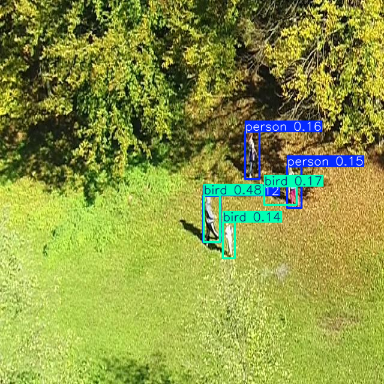

In [4]:
import cv2
import os
import random
from PIL import Image

CONFIDENCE = 0.12
INDEX = 8 # 4
RESIZE = (128 + 256, 128 + 256)
SAMPLE_SIZE = 1

images_folder = '/kaggle/input/sard-search-and-rescue/search-and-rescue/train/images'
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
# random_images = random.sample(image_files, SAMPLE_SIZE)
images = [image_files[INDEX]]
for image_file in images:
    image_path = os.path.join(images_folder, image_file)
    result_predict = model.predict(source=image_path, imgsz=(416), conf=CONFIDENCE)
    original_image = Image.open(image_path)
    # display(original_image)
    for result in result_predict:
        plot = result.plot()
        plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
        plot = cv2.resize(plot, RESIZE)
        display(Image.fromarray(plot))

In [5]:
result_predict[0].boxes.cls.numpy().tolist()

[14.0, 14.0, 0.0, 0.0, 14.0, 0.0]

In [6]:
result_predict[0].boxes.conf.numpy().tolist()

[0.4781332015991211,
 0.17469516396522522,
 0.15538643300533295,
 0.1541202962398529,
 0.1425071507692337,
 0.12100789695978165]

In [7]:
names = model.names
found = [int(item) for item in result_predict[0].boxes.cls.numpy().tolist()]
[names[f] for f in found]

['bird', 'bird', 'person', 'person', 'bird', 'person']

In [8]:
len(model.names)

80

In [9]:
len(image_files)

4041

In [10]:
import numpy as np
import os
import torch

from ultralytics import YOLO
from ultralytics.nn.modules.head import Detect
from ultralytics.utils import ops

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image

import json

class SaveIO:
    """Simple PyTorch hook to save the output of a nn.module."""
    def __init__(self):
        self.input = None
        self.output = None
        
    def __call__(self, module, module_in, module_out):
        self.input = module_in
        self.output = module_out

def load_and_prepare_model(model_path):
    # we are going to register a PyTorch hook on the important parts of the YOLO model,
    # then reverse engineer the outputs to get boxes and logits
    # first, we have to register the hooks to the model *before running inference*
    # then, when inference is run, the hooks will save the inputs/outputs of their respective modules
    model = YOLO(model_path)
    detect = None
    cv2_hooks = None
    cv3_hooks = None
    detect_hook = SaveIO()
    for i, module in enumerate(model.model.modules()):
        if type(module) is Detect:
            module.register_forward_hook(detect_hook)
            detect = module

            cv2_hooks = [SaveIO() for _ in range(module.nl)]
            cv3_hooks = [SaveIO() for _ in range(module.nl)]
            for i in range(module.nl):
                module.cv2[i].register_forward_hook(cv2_hooks[i])
                module.cv3[i].register_forward_hook(cv3_hooks[i])
            break
    input_hook = SaveIO()
    model.model.register_forward_hook(input_hook)

    # save and return these for later
    hooks = [input_hook, detect, detect_hook, cv2_hooks, cv3_hooks]

    return model, hooks


def is_text_file(file_path):
    # Check if the file extension indicates a text file
    text_extensions = ['.txt'] #, '.csv', '.json', '.xml']  # Add more extensions if needed
    return any(file_path.lower().endswith(ext) for ext in text_extensions)

def is_image_file(file_path):
    # Check if the file extension indicates an image file
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
    return any(file_path.lower().endswith(ext) for ext in image_extensions)


def plot_image(img_path, results, category_mapping=None, suffix='test', show_labels=True, include_legend=True):
    """
    Display the image with bounding boxes and their corresponding class scores.

    Args:
        img_path (str): Path to the image file.
        results (list): List of dictionaries containing bounding box information.
        category_mapping:
        suffix: what to append to the original image name when saving

    Returns:
        None
    """

    img = Image.open(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)

    for box in results:
        x0, y0, x1, y1 = map(int, box['bbox'])

        box_color = "r"  # red
        tag_color = "k"  # black
        max_score = max(box['activations'])
        max_category_id = box['activations'].index(max_score)
        category_name = max_category_id

        if category_mapping:
            max_category_name = category_mapping.get(max_category_id, "Unknown")
            category_name = max_category_name

        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor=box_color,
            label=f"{max_category_id}: {category_name} ({max_score:.2f})",
            facecolor='none'
        )
        ax.add_patch(rect)

        if show_labels:
            plt.text(
                x0,
                y0 - 50,
                f"{max_category_id} ({max_score:.2f})",
                fontsize="5",
                color=tag_color,
                backgroundcolor=box_color,
            )

    if include_legend:
        ax.legend(fontsize="5")

    plt.axis("off")
    plt.savefig(f'{os.path.basename(img_path).rsplit(".", 1)[0]}_{suffix}.jpg', bbox_inches="tight", dpi=300)


def write_json(results):
    # Create a list to store the predictions data
    predictions = []

    for result in results:
        image_id = os.path.basename(result['image_id'])#.split('.')[0]
        # image_id = result["image_id"]
        #image_id = os.path.basename(img_path).split('.')[0]
        max_category_id = result['activations'].index(max(result['activations']))
        category_id = max_category_id
        bbox = result['bbox']
        score = max(result['activations'])
        activations = result['activations']

        prediction = {
            'image_id': image_id,
            'category_id': category_id,
            'bbox': bbox,
            'score': score,
            'activations': activations
        }

        predictions.append(prediction)

    # Write the predictions list to a JSON file
    with open('predictions.json', 'w') as f:
        json.dump(predictions, f)


def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): Bounding box coordinates [x1, y1, w1, h1].
        box2 (list): Bounding box coordinates [x2, y2, w2, h2].

    Returns:
        float: Intersection over Union (IoU) value.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersect_x1 = max(x1, x2)
    intersect_y1 = max(y1, y2)
    intersect_x2 = min(x1 + w1, x2 + w2)
    intersect_y2 = min(y1 + h1, y2 + h2)

    intersect_area = max(0, intersect_x2 - intersect_x1 + 1) * max(0, intersect_y2 - intersect_y1 + 1)
    box1_area = w1 * h1
    box2_area = w2 * h2

    iou = intersect_area / float(box1_area + box2_area - intersect_area)
    return iou


# Apply Non-Maximum Suppression
def nms(boxes, iou_threshold=0.7):
    """
    Applies Non-Maximum Suppression (NMS) to a list of bounding box dictionaries.

    Args:
        boxes (list): List of dictionaries, each containing 'bbox', 'logits', and 'activations'.
        iou_threshold (float, optional): Intersection over Union (IoU) threshold for NMS. Default is 0.7.

    Returns:
        list: List of selected bounding box dictionaries after NMS.
    """
    # Sort boxes by confidence score in descending order
    sorted_boxes = sorted(boxes, key=lambda x: max(x['activations']), reverse=True)
    selected_boxes = []

    # Keep the box with highest confidence and remove overlapping boxes
    delete_idxs = []
    for i, box0 in enumerate(sorted_boxes):
        for j, box1 in enumerate(sorted_boxes):
            if i < j and calculate_iou(box0['bbox'], box1['bbox']) > iou_threshold:
                delete_idxs.append(j)

    # Reverse the order of delete_idxs
    delete_idxs.reverse()

    # now delete by popping them in reverse order
    filtered_boxes = [box for idx, box in enumerate(sorted_boxes) if idx not in delete_idxs]

    return filtered_boxes


def results_predict(img_path, model, hooks, threshold=0.5, iou=0.7, save_image = False, category_mapping = None):
    """
    Run prediction with a YOLO model and apply Non-Maximum Suppression (NMS) to the results.

    Args:
        img_path (str): Path to an image file.
        model (YOLO): YOLO model object.
        hooks (list): List of hooks for the model.
        threshold (float, optional): Confidence threshold for detection. Default is 0.5.
        iou (float, optional): Intersection over Union (IoU) threshold for NMS. Default is 0.7.
        save_image (bool, optional): Whether to save the image with boxes plotted. Default is False.

    Returns:
        list: List of selected bounding box dictionaries after NMS.
    """
    # unpack hooks from load_and_prepare_model()
    input_hook, detect, detect_hook, cv2_hooks, cv3_hooks = hooks

    # run inference; we don't actually need to store the results because
    # the hooks store everything we need
    model(img_path)

    # now reverse engineer the outputs to find the logits
    # see Detect.forward(): https://github.com/ultralytics/ultralytics/blob/b638c4ed9a24270a6875cdd47d9eeda99204ef5a/ultralytics/nn/modules/head.py#L22
    shape = detect_hook.input[0][0].shape  # BCHW
    x = []
    for i in range(detect.nl):
        x.append(torch.cat((cv2_hooks[i].output, cv3_hooks[i].output), 1))
    x_cat = torch.cat([xi.view(shape[0], detect.no, -1) for xi in x], 2)
    box, cls = x_cat.split((detect.reg_max * 4, detect.nc), 1)

    # assumes batch size = 1 (i.e. you are just running with one image)
    # if you want to run with many images, throw this in a loop
    batch_idx = 0
    xywh_sigmoid = detect_hook.output[0][batch_idx]
    all_logits = cls[batch_idx]

    # figure out the original img shape and model img shape so we can transform the boxes
    img_shape = input_hook.input[0].shape[2:]
    orig_img_shape = model.predictor.batch[1][batch_idx].shape[:2]

    # compute predictions
    boxes = []
    for i in range(xywh_sigmoid.shape[-1]): # for each predicted box...
        x0, y0, x1, y1, *class_probs_after_sigmoid = xywh_sigmoid[:,i]
        x0, y0, x1, y1 = ops.scale_boxes(img_shape, np.array([x0.cpu(), y0.cpu(), x1.cpu(), y1.cpu()]), orig_img_shape)
        logits = all_logits[:,i]
        
        boxes.append({
            'image_id': img_path,
            'bbox': [x0.item(), y0.item(), x1.item(), y1.item()], # xyxy
            'bbox_xywh': [(x0.item() + x1.item())/2, (y0.item() + y1.item())/2, x1.item() - x0.item(), y1.item() - y0.item()],
            'logits': logits.cpu().tolist(),
            'activations': [p.item() for p in class_probs_after_sigmoid]
        })

    # for debugging
    # top10 = sorted(boxes, key=lambda x: max(x['activations']), reverse=True)[:10]
    # plot_image(img_path, top10, suffix="before_nms")

    # NMS
    # we can keep the activations and logits around via the YOLOv8 NMS method, but only if we
    # append them as an additional time to the prediction vector. It's a weird hacky way to do it, but
    # it works. We also have to pass in the num classes (nc) parameter to make it work.
    boxes_for_nms = torch.stack([
        torch.tensor([*b['bbox_xywh'], *b['activations'], *b['activations'], *b['logits']]) for b in boxes
    ], dim=1).unsqueeze(0)
    
    # do the NMS
    nms_results = ops.non_max_suppression(boxes_for_nms, conf_thres=threshold, iou_thres=iou, nc=detect.nc)[0]
    
    # unpack it and return it
    boxes = []
    for b in range(nms_results.shape[0]):
        box = nms_results[b, :]
        x0, y0, x1, y1, conf, cls, *acts_and_logits = box
        activations = acts_and_logits[:detect.nc]
        logits = acts_and_logits[detect.nc:]
        box_dict = {
            'bbox': [x0.item(), y0.item(), x1.item(), y1.item()], # xyxy
            'bbox_xywh': [(x0.item() + x1.item())/2, (y0.item() + y1.item())/2, x1.item() - x0.item(), y1.item() - y0.item()],
            'best_conf': conf.item(),
            'best_cls': cls.item(),
            'image_id': img_path,
            'activations': [p.item() for p in activations],
            'logits': [p.item() for p in logits]
        }
        boxes.append(box_dict)

    return boxes


def run_predict(input_path, model, hooks, score_threshold=0.5, iou_threshold=0.7, save_image = False, save_json = False, category_mapping = None):
    """
    Run prediction with a YOLO model.

    Args:
        input_path (str): Path to an image file or txt file containing paths to image files.
        model (YOLO): YOLO model object.
        hooks (list): List of hooks for the model.
        threshold (float, optional): Confidence threshold for detection. Default is 0.5.
        iou_threshold (float, optional): Intersection over Union (IoU) threshold for NMS. Default is 0.7.
        save_image (bool, optional): Whether to save the image with boxes plotted. Default is False.
        save_json (bool, optional): Whether to save the results in a json file. Default is False.

    Returns:
        list: List of selected bounding box dictionaries for all the images given as input.
    """
    use_txt_input = False

    if is_text_file(input_path):
        use_txt_input = True

    if use_txt_input:
        with open(input_path, 'r') as f:
            img_paths = f.read().splitlines()
    else:
        img_paths = [input_path]

    all_results = []

    for img_path in img_paths:
        results = results_predict(img_path, model, hooks, score_threshold, iou=iou_threshold, save_image=save_image, category_mapping=category_mapping)

        all_results.extend(results)

    if save_json:
        write_json(all_results)

    return all_results



processing /kaggle/input/sard-search-and-rescue/search-and-rescue/train/images/gss562_jpg.rf.babd49e4307cd90124a00a2083f4e15a.jpg

image 1/1 /kaggle/input/sard-search-and-rescue/search-and-rescue/train/images/gss562_jpg.rf.babd49e4307cd90124a00a2083f4e15a.jpg: 640x640 (no detections), 219.1ms
Speed: 5.1ms preprocess, 219.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Processed 2 boxes


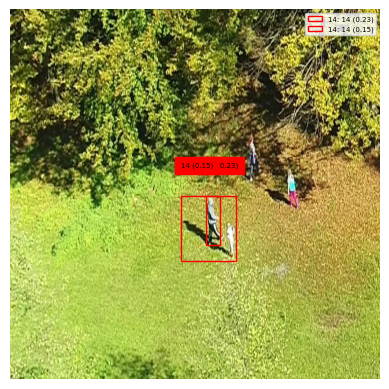

In [11]:
SAVE_TEST_IMG = True

img_path = '/kaggle/input/sard-search-and-rescue/search-and-rescue/train/images/gss562_jpg.rf.babd49e4307cd90124a00a2083f4e15a.jpg'
img_path = '/'.join([images_folder, image_files[INDEX]])
print(f'processing {img_path}')
threshold = 0.1
nms_threshold = 0.3

model, hooks = load_and_prepare_model(MODEL)
results = run_predict(img_path, model, hooks, score_threshold=threshold, iou_threshold=nms_threshold)
print("Processed", len(results), "boxes")
plot_image(img_path, results)

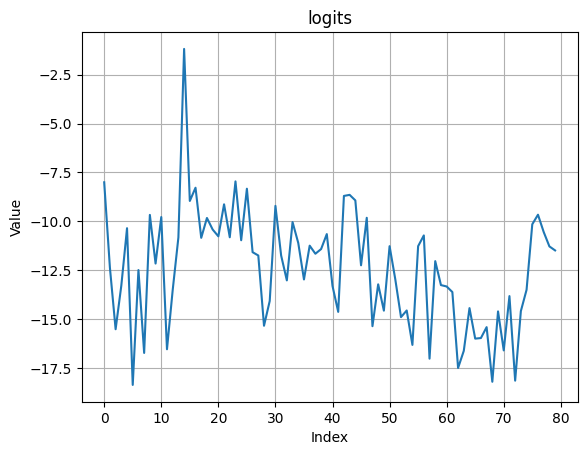

In [12]:
import matplotlib.pyplot as plt


plt.plot(results[0]['logits'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('logits')
plt.grid(True)
plt.show()

In [13]:
model.names[14]

'bird'